## Short Term Wind Climate 
**5. Filter data: (report page 30 - 33)**
- Outliers in wind speed and direction 
- Datagaps: Done in 'Overwiev'

**4. Interpolate:**
- Interpolate to the  one height of interest (= 150 meters for current turbine)

**7. Compare the both met masts:**
- Scatterplot: windspeed 150 m height mast one against windspeed 150m height mast 2 
- Same with the wind direction 
- Correlate with r^2 - linear correlation for both

**8. Short Term Wind Analysis**
- Mean, stdv of monthly and annual ws 
- Wind roses 
- Select parameters for Weibull model 
- Plot Weibull model 
- Diurnal profile of wind speed (blue) and wind direction (red) at HKW at 100 m MSL
- Monthly profile of the wind speed 
- Power curve of such a turbine
- Annual production of one turbine
- Annual production of wind farm


#### Import Libraries  

In [87]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np

#### File Paths

In [88]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

From 'Overview' we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

In [89]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

In [116]:
xrbuoy2

<xarray.Dataset> Size: 541kB
Dimensions:    (longitude: 1, latitude: 1, time: 67680, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.792
  * latitude   (latitude) float32 4B 54.5
  * time       (time) datetime64[ns] 541kB 2022-03-03 ... 2023-06-15T23:49:59...
  * height     (height) int32 24B 14 41 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [117]:
xrbuoy6

<xarray.Dataset> Size: 458kB
Dimensions:    (longitude: 1, latitude: 1, time: 57196, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.521
  * latitude   (latitude) float32 4B 54.4
  * time       (time) datetime64[ns] 458kB 2022-03-03 ... 2023-04-04T04:30:00
  * height     (height) int32 24B 14 42 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_6 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [90]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

In [91]:
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

In [207]:
#Filter all NaN values consistent! 
def filter_nan_values(arr):
    return arr[~np.isnan(arr)]

def filter_time_nan(time_variable):
    valid_time_rows = time_variable.astype('str') != 'NaT'
    filtered_time_variable = time_variable[valid_time_rows]
    return filtered_time_variable

def filter_and_align_data(time_var, wind_speed_var, wind_direction_var):
    valid_indices = ~np.isnan(time_var) & ~np.isnan(wind_speed_var) & ~np.isnan(wind_direction_var)
    filtered_time = time_var[valid_indices]
    filtered_wind_speed = wind_speed_var[valid_indices]
    filtered_wind_direction = wind_direction_var[valid_indices]
    return filtered_time, filtered_wind_speed, filtered_wind_direction

def process_wind_data_nan(time, winddirection, windspeed):
    # Initialize empty lists to store the results
    wd_nanfilters = []
    ws_nanfilters = []
    time_filtered = []
  

    # Loop over the range of indices and filter NaN values
    for i in range(0, 6):
        t, ws, wd = filter_and_align_data(time, windspeed[:, 0, 0, i], winddirection[:, 0, 0, i])
        time_filtered.append(t)
        ws_nanfilters.append(ws)
        wd_nanfilters.append(wd)


    #Print the length of the original arrays
    print(f'The original length of time array: {len(time)}')
    print(f'The original length of winddirection array: {len(winddirection)}')
    print(f'The original length of windspeed array: {len(windspeed)}')

    # Print the length of the filtered arrays and absolute filtered values
    for i, (filtered_time, filtered_ws, filtered_wd) in enumerate(zip(time_filtered, ws_nanfilters, wd_nanfilters)):
        print(f'The length of timefiltered{i+1} array: {len(filtered_time)}')
        print(f'The length of ws_nanfilter{i+1} array: {len(filtered_ws)}')
        print(f'The length of wd_nanfilter{i+1} array: {len(filtered_wd)}')
    
    return  time_filtered, wd_nanfilters, ws_nanfilters

time2_filtered, wd2_nanfilters, ws2_nanfilters = process_wind_data_nan(time2, winddirection_buoy_2, windspeed2)
time6_filtered, wd6_nanfilters, ws6_nanfilters = process_wind_data_nan(time6, winddirection_buoy_6, windspeed6)

The original length of time array: 67680
The original length of winddirection array: 67680
The original length of windspeed array: 67680
The length of timefiltered1 array: 56633
The length of ws_nanfilter1 array: 56633
The length of wd_nanfilter1 array: 56633
The length of timefiltered2 array: 56901
The length of ws_nanfilter2 array: 56901
The length of wd_nanfilter2 array: 56901
The length of timefiltered3 array: 56047
The length of ws_nanfilter3 array: 56047
The length of wd_nanfilter3 array: 56047
The length of timefiltered4 array: 55494
The length of ws_nanfilter4 array: 55494
The length of wd_nanfilter4 array: 55494
The length of timefiltered5 array: 55130
The length of ws_nanfilter5 array: 55130
The length of wd_nanfilter5 array: 55130
The length of timefiltered6 array: 54995
The length of ws_nanfilter6 array: 54995
The length of wd_nanfilter6 array: 54995
The original length of time array: 57196
The original length of winddirection array: 57196
The original length of windspeed a

In [232]:
#height of interrest at height 140 m and 200 m -> indice 3 and 4!
a = ws6_nanfilters[3].shape[0]
b = ws6_nanfilters[4].shape[0]

print(a>b)

True


In [228]:
array_140m = ws6_nanfilters[3]
array_200m = ws6_nanfilters[4]

# Align the arrays by truncating the longer array to match the length of the shorter one
min_length = min(array_140m.shape[0], array_200m.shape[0])
array_140m = array_140m[:min_length]
array_200m = array_200m[:min_length]

# Define the heights
height_140m = 140
height_200m = 200
height_150m = 150

# Linear interpolation factor
factor = (height_150m - height_140m) / (height_200m - height_140m)

# Interpolating the values manually
interpolated_data = array_140m.data + factor * (array_200m.data - array_140m.data)

# Combine masks and apply to interpolated data
interpolated_mask = np.logical_or(array_140m.mask, array_200m.mask)
interpolated_values = np.ma.masked_array(interpolated_data, mask=interpolated_mask)

# Print or return the interpolated values
print(type(interpolated_values))
print(interpolated_data.shape)
print(time6_filtered[4].shape)

<class 'numpy.ma.core.MaskedArray'>
(55199,)
(55199,)


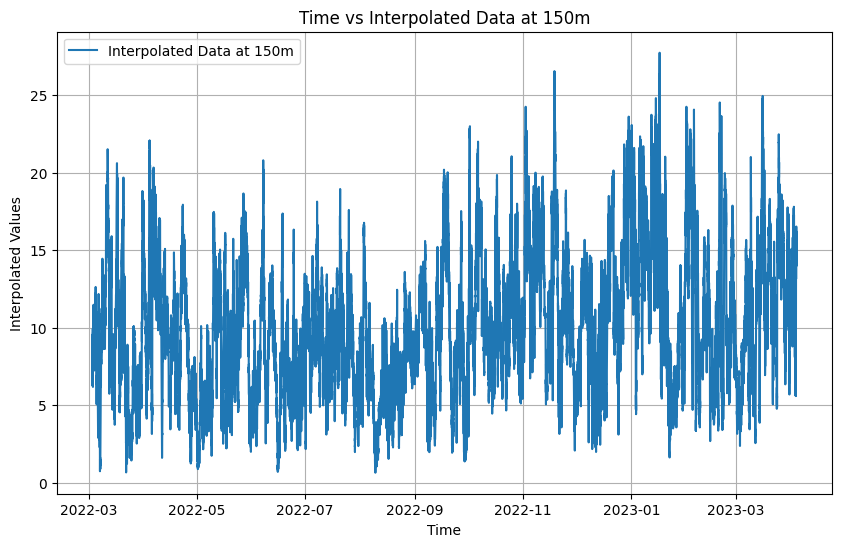

In [231]:
# Plotting time6_filtered_4 against interpolated_data
plt.figure(figsize=(10, 6))
plt.plot(time6_filtered[4], interpolated_data, label='Interpolated Data at 150m')
plt.xlabel('Time')
plt.ylabel('Interpolated Values')
plt.title('Time vs Interpolated Data at 150m')
plt.legend()
plt.grid(True)
plt.show()